In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
main_image = cv2.imread('Raw/60minutes.jpg')
full_image_mask = cv2.imread('Done/binary_60minutes.png', cv2.IMREAD_GRAYSCALE)
houses_mask_rgb = cv2.imread('60minutes-mask2.png')

def resize_mask(mask, image_shape):
    resized_mask = cv2.resize(mask, (image_shape[1], image_shape[0]))
    return resized_mask
full_image_mask = resize_mask(full_image_mask, main_image.shape)
houses_mask_rgb = resize_mask(houses_mask_rgb, main_image.shape)

# Step 1: Convert the RGB houses mask to a binary mask
# Assuming the houses are white (255, 255, 255) in the RGB mask
houses_mask_gray = cv2.cvtColor(houses_mask_rgb, cv2.COLOR_BGR2GRAY)
_, binary_houses_mask = cv2.threshold(houses_mask_gray, 1, 255, cv2.THRESH_BINARY)

# Step 2: Remove the houses from the full image mask
modified_full_image_mask = cv2.bitwise_and(full_image_mask, cv2.bitwise_not(binary_houses_mask))


# Dilate the binary mask slightly
kernel = np.ones((15, 15), np.uint8)  # You can adjust the size of the kernel for more or less dilation
star_trails_mask = cv2.dilate(modified_full_image_mask, kernel, iterations=1)



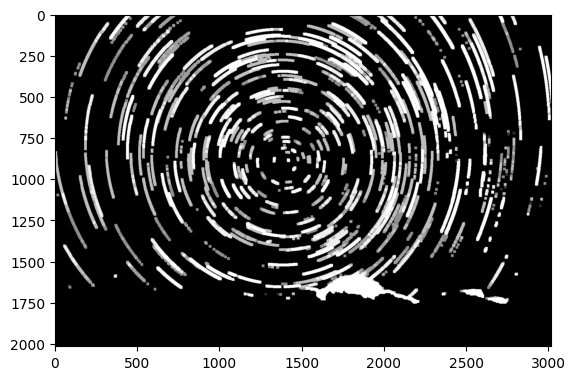

In [34]:
plt.imshow(star_trails_mask, cmap = 'gray')

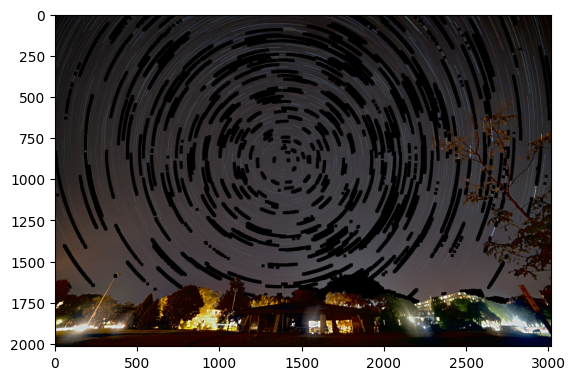

In [2]:
# Step 3: Subtract the star trails from the main image using the modified full image mask
# Create a mask for the star trails only
#star_trails_mask = cv2.bitwise_and(full_image_mask, modified_full_image_mask)

# Create a copy of the main image to subtract star trails from
main_image_no_stars = main_image.copy()
main_image_no_stars[star_trails_mask > 0] = 0

plt.imshow(main_image_no_stars[:,:,::-1])

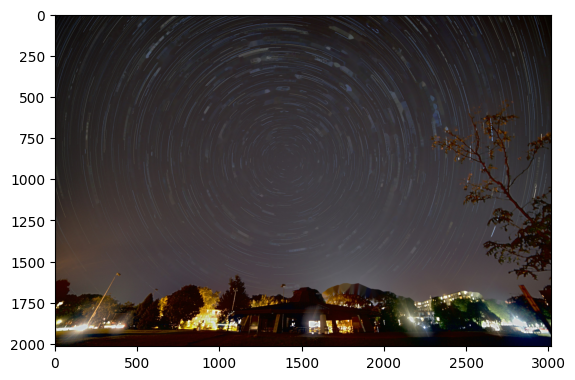

In [36]:
# Step 4: Inpaint the pixels that originally contained the star trails
# Use the star_trails_mask to determine the regions to inpaint
inpainted_image = cv2.inpaint(main_image_no_stars, star_trails_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.imshow(inpainted_image[:,:,::-1])

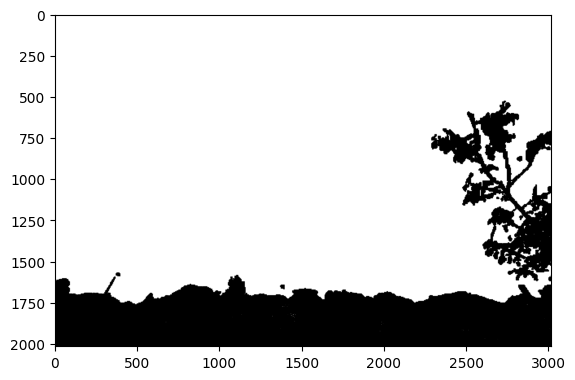

In [3]:
# Step 5: Apply Gaussian blurring to areas not covered by the houses mask
# Invert the dilated houses mask to get the regions not covered by the houses
non_houses_mask = cv2.bitwise_not(binary_houses_mask)
plt.imshow(non_houses_mask, cmap = 'gray')

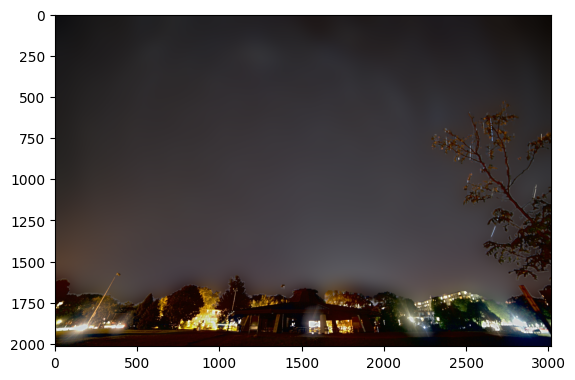

In [58]:
blurred_image = inpainted_image.copy()
blurred_image[non_houses_mask > 0] = cv2.GaussianBlur(blurred_image, (345, 345), 0)[non_houses_mask > 0]
plt.imshow(blurred_image[:,:,::-1])

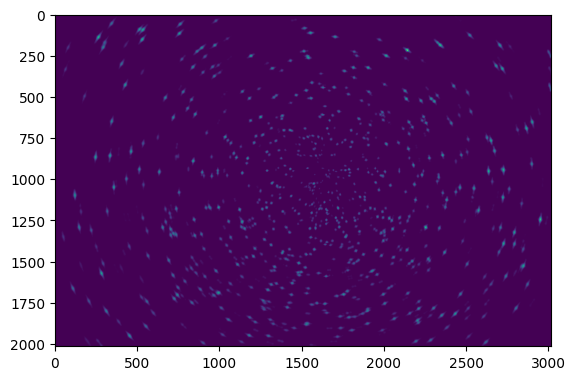

In [63]:
stars = cv2.imread('gd_fista_tv_recon.png',0)
stars = resize_mask(stars, blurred_image.shape)
plt.imshow(stars)

mask = cv2.threshold(stars, 90, 255, cv2.THRESH_BINARY)[1]
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
#combined_image = cv2.bitwise_and(blurred_image, blurred_image, mask=mask)
#plt.imshow(combined_image)
combined_image = cv2.bitwise_xor(blurred_image, mask_rgb)

#finalimage = cv2.bitwise_or(blurred_image, stars)

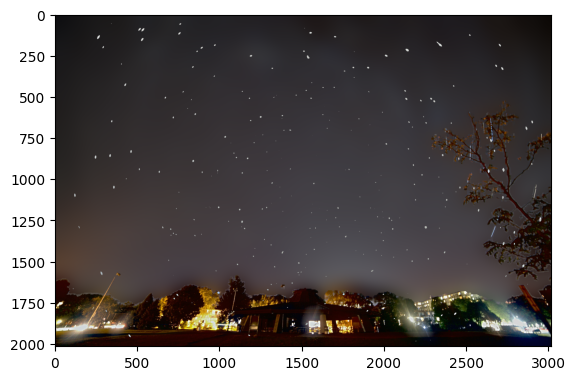

In [64]:
plt.imshow(combined_image[:,:,::-1])

In [66]:
cv2.imwrite('final_60minutes.png',combined_image)

True